In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cards-image-datasetclassification/53cards-53-(200 X 200)-100.00.h5
/kaggle/input/cards-image-datasetclassification/cards.csv
/kaggle/input/cards-image-datasetclassification/14card types-14-(200 X 200)-94.61.h5
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/5.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/1.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/4.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/3.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/2.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/5.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/1.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/4.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/3.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/2.jpg
/kaggle/input/cards-image-datas

# 1. order libraries

In [2]:
import matplotlib.pyplot as plt 
import sys 
import tqdm
import os
import glob
import matplotlib.image as mpimg
from torch.utils.data import Dataset , DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2

# 2.show photos

In [3]:
image = '/kaggle/input/cards-image-datasetclassification/train/ace of clubs'
image_files = [f for f in os.listdir(image) if f.endswith(('.png','.jpg','.jpeg','.gif'))][:3]

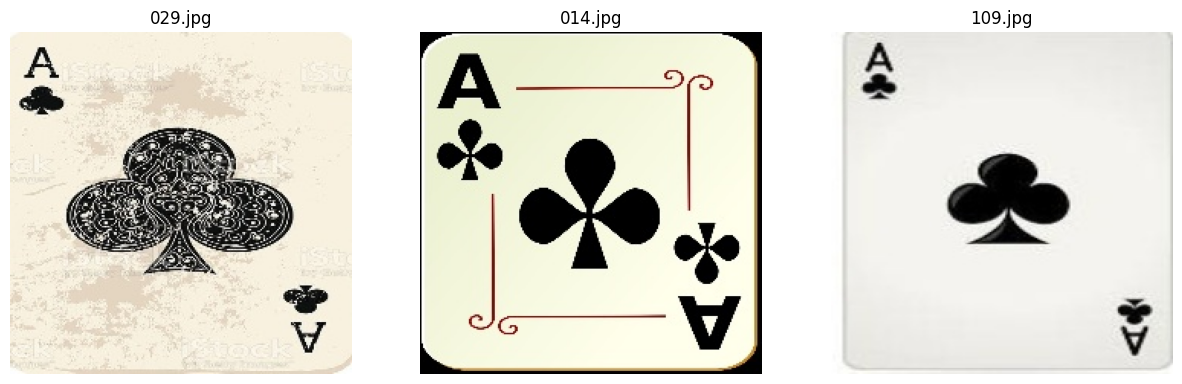

In [4]:
fig , axes = plt.subplots(1,3,figsize = (15,5)) 
for i , image_file in enumerate(image_files):
    image_path = os.path.join(image, image_file ) 
    img = mpimg.imread(image_path) 
    axes[i].imshow(img) 
    axes[i].set_title(image_file) 
    axes[i].axis('off')

# 4. Create information data for the model 

In [5]:
class Playcard(Dataset): 
    def __init__(self, data_dir , transform = None):
        self.data = ImageFolder(data_dir , transform = transform) 
    def __len__(self):
        return len(self.data) 
    def __getitem__(self,idx):
        return self.data[idx]
    @property 
    def classes(self):
        return self.data.classes

In [6]:
dataset = Playcard(data_dir = '/kaggle/input/cards-image-datasetclassification/train')


In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = Playcard(data_dir, transform)

In [8]:
image , label  = dataset[100] 
image.shape

torch.Size([3, 128, 128])

In [9]:
for image , label in dataset:
    break

In [10]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [11]:
for images , labels in dataloader: 
    break

In [12]:
labels

tensor([26, 51, 52,  1, 52, 41, 21, 19, 14, 18, 12, 28, 15,  9, 30, 28,  8, 19,
        14, 27,  0, 44, 36, 18, 22,  4, 41, 30, 50, 19, 35,  3])

# 4. PyTorch model

In [13]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision
import timm

In [14]:
class Simple(nn.Module):
    def __init__(self,num_classes = 53): 
        super(Simple,self).__init__() 
        self.base_model = timm.create_model('efficientnet_b0',pretrained = True) 
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) 

        enet_out_size = 1280 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size , num_classes)
        )
    def forward(self,x):
        x = self.features(x) 
        output = self.classifier(x) 
        return output

In [15]:
model = Simple(num_classes = 53) 
print(str(model)[:500])

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Simple(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
         


In [16]:
example_out = model(images) 
example_out.shape

torch.Size([32, 53])

In [17]:
criterion = nn.CrossEntropyLoss()

criterion(example_out , labels)

print(example_out.shape , labels .shape)

torch.Size([32, 53]) torch.Size([32])


In [18]:
optimizer = optim.Adam(model.parameters(),lr = 0.00)

In [19]:
train_dataset = Playcard('/kaggle/input/cards-image-datasetclassification/train', transform = transform) 


In [20]:
test_dataset = Playcard('/kaggle/input/cards-image-datasetclassification/test',transform = transform) 
val_dataset = Playcard('/kaggle/input/cards-image-datasetclassification/valid', transform = transform)

In [21]:
train_loder = DataLoader(train_dataset , batch_size = 32, shuffle = True , num_workers = 2) 
val_loader = DataLoader(val_dataset , batch_size = 32, shuffle = False ) 
test_loader = DataLoader(val_dataset , batch_size = 32 , shuffle  = False)

In [22]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

num_epochs = 1
in_classes = 2
in_channel = 3
learning_rate = 0.001
batch_size = 1

model = Simple(num_classes = 53) 
model.to(device)

Cirterion = nn.CrossEntropyLoss() 
Optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loder):
        # Get data to cuda if possible,
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = Cirterion(scores, targets)

        losses.append(loss.item())

        # backward
        Optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        Optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

    

Cost at epoch 0 is 1.489949570540105


In [24]:
from tqdm.notebook import tqdm

In [25]:
val_losses 
model.eval()
running_loss = 0.0
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
         
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs},Validation loss: {val_loss}")

NameError: name 'val_losses' is not defined

# 5.plot data loss

In [ ]:
plt.plot(losses , label = 'Training loss') 
plt.plot(val_loss , label = 'Validation loss')
plt.legend()
plt.title('loss over opohs')

# 6. predicted model

In [ ]:
from PIL import Image

In [ ]:
def preprocss_image(image_path , transform):
    image = Image.open(image_path).convert('RGB')
    return image , transform(image).unsqueeze(0) 


def predict(model, image_tensor , device):
    model.eval() 
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor) 
        probabilties = torch.nn.functional.softmax(outputs , dim = 1) 
    return probabilties.cpu().numpy().flatten()


def visualize_predictions(original_image , probabilities , class_names):
    fig , axarr = plt.subplots(1,2,figsize = (14,7))
    axarr[0].imshow(original_image)
    axarr[0].axis('off') 
    

    axarr[1].barh(class_names , probabilities) 
    axarr[1].set_xlabel('Probability') 
    axarr[1].set_title('class Predictions') 
    axarr[1].set_xlim(0,1) 

    plt.tight_layout() 
    

In [ ]:
from glob import glob
test_images = glob('/kaggle/input/cards-image-datasetclassification/test/*/*') 
test_examples = np.random.choice(test_images , 10) 

for example in test_examples:
    original_image , image_tensor = preprocss_image(example , transform) 
    probabilites  = predict(model  , image_tensor , device) 

    class_names = dataset.classes 
    visualize_predictions(original_image , probabilites  , class_names)